# CTD2 (aka CTRP) Drug Sensitivity Data Import
**Local Version**: 2
**Source Version**: 2.0

This notebook will import raw CTD (release 2) drug sensitivity data.  The portal for this data is hosted on an NCI domain at https://ctd2.nci.nih.gov/dataPortal/ which links to an ftp site like this one for "
Cancer Therapeutics Response Portal (CTRP v2, 2015) dataset": ftp://caftpd.nci.nih.gov/pub/dcc_ctd2/Broad/CTRPv2.0_2015_ctd2_ExpandedDataset

Both CTRP/CTD v1 and v2 datasets are available on this FTP server though this notebook is only concerned with the most recent version (2.0).

Relevant definitions of fields found in ctd_v2_drug-sensitivity.zip/v20._COLUMNS.txt:

- experiment_id   serial number for experiment performed during CTRPv2 data collection
- conc_pts_fit    number of concentration-response points participating in curve fit
- fit_num_param   number of free parameters in curve fit
- p1_conf_int_high        "upper bound of confidence interval (95%) for curve fit parameter 1, center: log2(apparent_ec50_umol)"
- p1_conf_int_low "lower bound of confidence interval (95%) for curve fit parameter 1, center: log2(apparent_ec50_umol)"
- p2_conf_int_high        "upper bound of confidence interval (95%) for curve fit parameter 2, slope parameter"
- p2_conf_int_low "lower bound of confidence interval (95%) for curve fit parameter 2, slope parameter"
- p4_conf_int_high        "upper bound of confidence interval (95%) for curve fit parameter 4, baseline: high-concentration percent viability"
- p4_conf_int_low "lower bound of confidence interval (95%) for curve fit parameter 4, baseline: high-concentration percent viability"
- p1_center       "curve fit parameter 1, center: log2(apparent_ec50_umol)"
- p2_slope        "curve fit parameter 2, slope parameter"
- p3_total_decline        "curve fit parameter 3, total decline in percent viability (not a free parameter): 1-p4_baseline"
- p4_baseline     "curve fit parameter 4, baseline: high-concentration percent viability"
- apparent_ec50_umol      apparent effective concentration at which 50% of total decline is observed: 2^p1_center
- pred_pv_high_conc       predicted percent viability at highest concentration tested (in principle similar to p4_baseline for well-behaved curves)
- area_under_curve        integrated area under the sigmoid-fit concentration-response curve

In [36]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import io_utils as io
from py_utils import assertion_utils

source_file = 'ftp://caftpd.nci.nih.gov/pub/dcc_ctd2/Broad/CTRPv2.0_2015_ctd2_ExpandedDataset/CTRPv2.0_2015_ctd2_ExpandedDataset.zip'
dest_file = db.raw_file(src.CTD_v2, 'drug-sensitivity.zip')

2016-11-30 11:41:42,408:INFO:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [3]:
def get_data(filename):
    return io.extract_ftp_zip_to_data_frame(source_file, dest_file, filename, sep='\t')

In [4]:
d_auc = get_data('v20.data.curves_post_qc.txt')
d_auc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395263 entries, 0 to 395262
Data columns (total 17 columns):
experiment_id         395263 non-null int64
conc_pts_fit          395263 non-null int64
fit_num_param         395263 non-null int64
p1_conf_int_high      395263 non-null float64
p1_conf_int_low       395263 non-null float64
p2_conf_int_high      395263 non-null float64
p2_conf_int_low       395263 non-null float64
p4_conf_int_high      306346 non-null float64
p4_conf_int_low       306346 non-null float64
p1_center             395263 non-null float64
p2_slope              395263 non-null float64
p3_total_decline      395263 non-null float64
p4_baseline           395263 non-null float64
apparent_ec50_umol    395263 non-null float64
pred_pv_high_conc     395263 non-null float64
area_under_curve      395263 non-null float64
master_cpd_id         395263 non-null int64
dtypes: float64(13), int64(4)
memory usage: 51.3 MB


In [5]:
d_cmpd = get_data('v20.meta.per_compound.txt')
d_cmpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 11 columns):
master_cpd_id                     545 non-null int64
cpd_name                          545 non-null object
broad_cpd_id                      545 non-null object
top_test_conc_umol                545 non-null float64
cpd_status                        545 non-null object
inclusion_rationale               545 non-null object
gene_symbol_of_protein_target     415 non-null object
target_or_activity_of_compound    545 non-null object
source_name                       495 non-null object
source_catalog_id                 359 non-null object
cpd_smiles                        545 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 46.9+ KB


In [6]:
d_exp = get_data('v20.meta.per_experiment.txt')

# At TOW, there were 907 unique experiment ids but 1,061 records in this dataset due to
# many "near-duplicates" where everything is the same except for run_id and experiment_date.
# As these are not critical fields or fields that appear in other datasets, it seems safe
# to assume they can be summarized to single values to make sure that experiment records are unique
# to the "experiment_id"
c_repeat = ['experiment_date', 'run_id']
d_exp = d_exp.groupby(d_exp.columns.difference(c_repeat).tolist())[c_repeat].max().reset_index()
assert not np.any(d_exp['experiment_id'].duplicated())

d_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 9 columns):
baseline_signal    907 non-null float64
cells_per_well     907 non-null int64
culture_media      907 non-null object
experiment_id      907 non-null int64
growth_mode        907 non-null object
master_ccl_id      907 non-null int64
snp_fp_status      907 non-null object
experiment_date    907 non-null int64
run_id             907 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 63.9+ KB


In [7]:
d_cl = get_data('v20.meta.per_cell_line.txt')
d_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 6 columns):
master_ccl_id          1107 non-null int64
ccl_name               1107 non-null object
ccl_availability       1107 non-null object
ccle_primary_site      1045 non-null object
ccle_primary_hist      1032 non-null object
ccle_hist_subtype_1    779 non-null object
dtypes: int64(1), object(5)
memory usage: 52.0+ KB


## Merge Datasets

In [52]:
d = pd.merge(d_auc, d_cmpd, on='master_cpd_id')
d = pd.merge(d, d_exp, on='experiment_id')
d = pd.merge(d, d_cl, on='master_ccl_id')

c_m = {
    'experiment_id': 'EXPERIMENT_ID',
    'broad_cpd_id': 'DRUG_ID:BROAD',
    'master_cpd_id': 'DRUG_ID:CTD',
    'ccl_name': 'CELL_LINE_ID',
    'master_ccl_id': 'CELL_LINE_ID:CTD',
    'cpd_name': 'DRUG_NAME',
    'cpd_smiles': 'SMILES',
    'cpd_status': 'STATUS',
    'p1_center': 'LOG2_EC50',
    #'apparent_ec50_umol': 'EC50',
    'area_under_curve': 'AUC',
    'conc_pts_fit': 'N_POINTS_FIT'
}
d = d[list(c_m.keys())].rename(columns=c_m)

# Clip AUC and Log EC50 values to more reasonable ranges
d['AUC'] = d['AUC'].clip(0, 20)
d['LOG2_EC50'] = d['LOG2_EC50'].clip(-20, 20)

# Make sure no values are null, that there are no mixed-types, and
# that all records are unique to a cell line + compound + experiment combination
assert not np.any(d.isnull())
assert not np.any(d[['CELL_LINE_ID', 'DRUG_ID:CTD', 'EXPERIMENT_ID']].duplicated())

# Ensure that cell line names and ids do not ever conflict (if this is true,
# then they can be treated as a single unique identifier together)
assert d.groupby('CELL_LINE_ID')['CELL_LINE_ID:CTD'].nunique().max() == 1
assert d.groupby('CELL_LINE_ID:CTD')['CELL_LINE_ID'].nunique().max() == 1

assertion_utils.assert_object_types(d)
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395263 entries, 0 to 395262
Data columns (total 11 columns):
DRUG_NAME           395263 non-null object
CELL_LINE_ID        395263 non-null object
AUC                 395263 non-null float64
EXPERIMENT_ID       395263 non-null int64
DRUG_ID:BROAD       395263 non-null object
LOG2_EC50           395263 non-null float64
N_POINTS_FIT        395263 non-null int64
CELL_LINE_ID:CTD    395263 non-null int64
DRUG_ID:CTD         395263 non-null int64
STATUS              395263 non-null object
SMILES              395263 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.2+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11315dcc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119cec9b0>]], dtype=object)

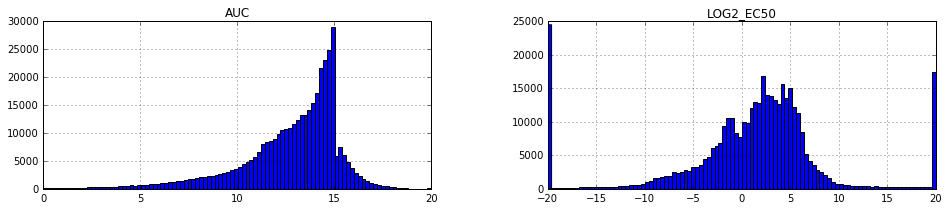

In [22]:
d[['AUC', 'LOG2_EC50']].hist(bins=100, figsize=(16,3))

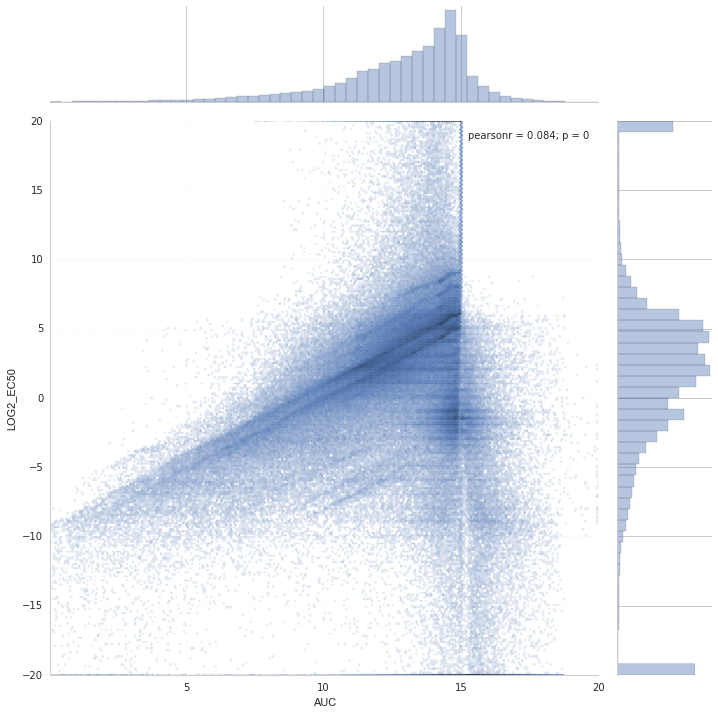

In [34]:
sns.jointplot('AUC', 'LOG2_EC50', data=d, kind='hex', bins='log', size=10)

In [48]:
# Plot the above with colors by drugs
ids = d['DRUG_ID:CTD'].drop_duplicates().sample(n=50).values
d_plt = d[d['DRUG_ID:CTD'].isin(ids)]
traces = [
    go.Scatter(x=g['AUC'], y=g['LOG2_EC50'], name=k, mode='markers', 
               showlegend=True, text=g['CELL_LINE_ID'], opacity=.8) 
    for k, g in d_plt.groupby('DRUG_ID:CTD')
]
fig = go.Figure(data=traces, layout=go.Layout(hovermode='closest', width=1000, height=600))
plty.offline.iplt(fig)

In [53]:
c_val = ['AUC', 'LOG2_EC50']
c_grp = ['CELL_LINE_ID', 'CELL_LINE_ID:CTD', 'DRUG_ID:CTD']
c_meta = ['SMILES', 'DRUG_NAME', 'STATUS', 'DRUG_ID:BROAD']

# Resolve meta columns to first value after ensuring there is only one
def agg_meta(x):
    assert x.nunique() == 1
    return x.iloc[0]

# Aggregate multiple values as sequence
def agg_value(x):
    # Using tuple here instead of list because .agg apparently interprets
    # lists as non-scalar objects.
    return tuple(x.values)

d_agg = d.groupby(c_grp).agg({
    **{c:agg_value for c in c_val},
    **{c:agg_meta for c in c_meta}
}).reset_index()

d_agg.head()

,CELL_LINE_ID,CELL_LINE_ID:CTD,DRUG_ID:CTD,DRUG_ID:BROAD,SMILES,AUC,STATUS,DRUG_NAME,LOG2_EC50
0,2004,155823,3588,BRD-K86574132,CC(C)N1C(=O)S\C(=C\c2ccc(Sc3nc4ccccc4[nH]3)o2)...,"(15.532,)",probe,BRD4132,"(0.8461,)"
1,2004,155823,12877,BRD-K35716340,C(Cn1c2ccccc2c2ccccc12)c1nc2ccccc2[nH]1,"(14.805,)",probe,BRD6340,"(-20.0,)"
2,2004,155823,17712,BRD-K89692698,C1CN(CCO1)c1nnc(-c2ccccc2)c(n1)-c1ccccc1,"(14.935,)",probe,ML006,"(9.046,)"
3,2004,155823,18311,BRD-A18763547,OC(CN1CCNCC1)Cn1c2ccc(Br)cc2c2cc(Br)ccc12,"(12.685,)",probe,Bax channel blocker,"(3.049,)"
4,2004,155823,19153,BRD-K89329876,CC(C)(C)c1ccc2cc(C#N)c(cc2c1)C#N,"(16.176,)",probe,BRD9876,"(-0.4948,)"


In [54]:
d_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387130 entries, 0 to 387129
Data columns (total 9 columns):
CELL_LINE_ID        387130 non-null object
CELL_LINE_ID:CTD    387130 non-null int64
DRUG_ID:CTD         387130 non-null int64
DRUG_ID:BROAD       387130 non-null object
SMILES              387130 non-null object
AUC                 387130 non-null object
STATUS              387130 non-null object
DRUG_NAME           387130 non-null object
LOG2_EC50           387130 non-null object
dtypes: int64(2), object(7)
memory usage: 26.6+ MB


## Export

In [55]:
assert np.all(pd.notnull(d_agg))
db.save(d_agg, src.CTD_v2, db.IMPORT, 'drug-sensitivity')

'/Users/eczech/data/research/mgds/import/ctd_v2_drug-sensitivity.pkl'